<a href="https://colab.research.google.com/github/chumpblocckami/Clustering_byTh/blob/master/Clustering_byTh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Create functions for graph inspection***

I'll recycle some function that i used to generate random graphs.

For this notebook we'll only use the getPoints() function.

In [0]:
import random
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [2]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#create n number point that can vary from lower to upper.
#IN: None (default values) or int number of points, int lower bound and int upper bound.
#OUT: Array of points
def getPoints(n=10,lower=1,upper=20):
  punti = []
  for i in range(0,n):
    punti.append([np.random.randint(lower,upper),np.random.randint(lower,upper)])
  return punti

#create a connection between two points: if 'peso' is specified, it creates a weight for each connection.
#IN: array of points, None (default values) or boolean peso
#OUT: array of connections, array of connections and weights
def getConnections(punti,peso=False):
  connections = []
  weights = []
  if peso == True:
    for punto in punti:
      choice = random.choice(punti)
      connections.append([[punto[0],choice[0]],[punto[1],choice[1]]])
    for i in range(0,len(connections)):
      weights.append(random.uniform(0,1))
    return connections,weights
  else:
    for punto in punti:
      choice = random.choice(punti)
      connections.append([[punto[0],choice[0]],[punto[1],choice[1]]])
    return connections

#Assign to each node a name
#IN: array of points
#OUT: array of digits
def getNames(punti):
  return ["A_"+str(x) for x in range(0,len(points))]

#create a graph to display points and connections.
#IN: array of points, array of connections, array of digits, None (default values) or an array of weights
#OUT matplotlib plot
def getGraph(points,connections=[],digits=[],weights=[],title="Graph"):
  plt.figure(dpi=100)
  plt.title(title)
  #i set the limit for graphic purpose, feel free to delete it
  plt.xlim([0,len(points)/2+1])
  plt.ylim([0,len(points)/2+1])
  #this is meant to plot the connections, if there are weights the width of lines changes
  if (len(weights)!=0):
    for i in range(0,len(connections)):
      plt.plot(connections[i][0],connections[i][1],color="red",linewidth=weights[i]);
  elif(len(connections)!=0):
    for i in connections:
      plt.plot(i[0],i[1],color="red")
  else:
    pass
  #this is meant to plot the points
  for i in points:
    plt.scatter(i[0],i[1],color="black",s=4);
  #this is meant to annotate the graph
  if(len(digits)!=0):
    for i in range(0,len(points)):
      plt.annotate(digits[i],xy=(points[i][0]+0.1,points[i][1]+0.2),size=7,)
  else:
    pass

## **Clustering using Euclidean Distance**
Let's create two cluster, then let's see which point is the nearest and the farthest, and set the points near them as clusters. Then,calculate the mean of all points that belongs to a cluster, and then point there a centroids, and then reassing all the points to the nearest cluster. Iterate this process for until it converge to a point where the cluster of points don't change.\n

**TL;DR:**
1. Create two random cluster
2. Compute the nearest and farthest point from the origin
3. Assign each point to one cluster based on nearest and farthest point
4. Calculate the median point of each cluster, and assing it as a centroids for that cluster
5. Recalculate the distance from each point to the centroids, then reassing the cluster if it changes
6. Iterate point 5 until each point don't change cluster each iteration.

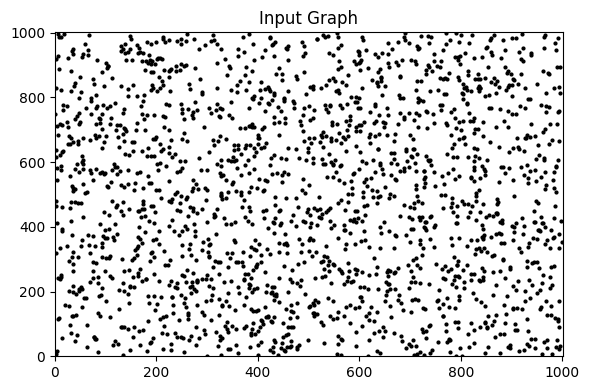

In [4]:
punti_generati= 1000
n_cluster = 1000

cluster1 = getPoints(n_cluster,1,punti_generati)
cluster2 = getPoints(n_cluster,1,punti_generati)

all_points = cluster1 +cluster2

getGraph(points=all_points,title="Input Graph")
plt.tight_layout()
plt.savefig("drive/My Drive/Cluster/Cluster.png")
plt.show()

In [0]:
#Use a dictionary for store the informations about the points 
#(it's possible to use also pandas but i wanted to keep things simple)
c = 0
punti = {}
for i in all_points:
  punti[str(c)] = {"X":i[0],"Y":i[1]}
  c = c+1

In [0]:
#for each point, find the distance from the origin:
def Euclidean(x1,y1,x2,y2):
  return np.sqrt(((x1-x2)**2 + (y1-y2)**2)**2)

dists = []
c = 0
for i in all_points:
  dist = Euclidean(0,0,i[0],i[1])
  punti[str(c)].update({"Dist_Origine":dist})
  dists.append(dist)
  c = c+1

In [7]:
#find the farthest and the nearest point
min_point = all_points[dists.index(min(dists))]
max_point = all_points[dists.index(max(dists))]
print("\nNearest point: ",min_point," distance: ",min(dists),"\nFarthest point ",max_point," distance: ",max(dists))
print("Range of intrest: ",max(dists)-min(dists))


Nearest point:  [1, 3]  distance:  10.0 
Farthest point  [992, 984]  distance:  1952320.0
Range of intrest:  1952310.0


In [0]:
#for each point, find the distance between it and the farthest and nearest point
c = 0
max_dists = []
for i in all_points:
  dist_max = Euclidean(max_point[0],max_point[1],i[0],i[1])
  dist_max = np.sqrt(((max_point[0]-int(i[0]))**2 + (max_point[1]-int(i[1]))**2)**2)
  punti[str(c)].update({"Dist_Max":dist_max})
  max_dists.append(dist_max)
  c = c+1

c = 0
min_dists = []
for i in all_points:
  dist_min = np.sqrt(((min_point[0]-int(i[0]))**2 + (min_point[1]-int(i[1]))**2)**2)
  punti[str(c)].update({"Dist_Min":dist_min})
  min_dists.append(dist_min)
  c = c+1

In [0]:
#Assign the cluster based on the distance between the extreme points:
def AssignCluster(punti,x,y,validation=[]):
  validation = []
  c = 0
  min_dists = []
  for i in punti.items():
    if(i[1][x] > i[1][y]):
      punti[str(c)].update({"Cluster":"cluster1"})
      if(len(validation)!=0):
        validation.append("cluster1")
    else:
      punti[str(c)].update({"Cluster":"cluster2"})
      if(validation):
        validation.append("cluster2")
    c = c+1
  if(len(validation)!=0):
      return punti,validation
  else:
      return punti
punti = AssignCluster(punti,x="Dist_Max",y="Dist_Min")

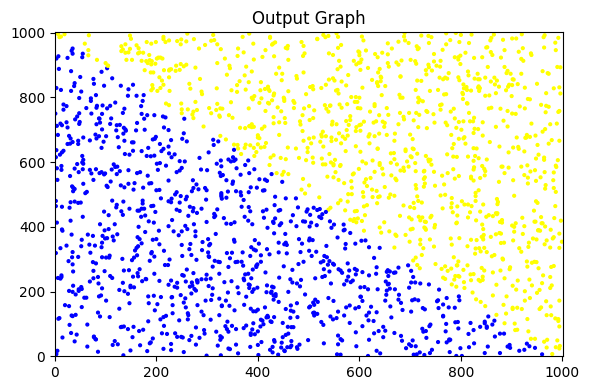

In [10]:
plt.figure(dpi=100)
plt.title("Output Graph")
plt.xlim([0,punti_generati+1])
plt.ylim([0,punti_generati+1])
colors = {'cluster1':'blue', 'cluster2':'yellow',}
data=pd.DataFrame(punti).transpose()
plt.scatter(x=data.X,y=data.Y,c=data.Cluster.apply(lambda x: colors[x],),s=4)
plt.tight_layout()
plt.savefig("drive/My Drive/Cluster/Cluster0.png")
plt.show()

In [0]:
#get the centroids using a mean point in each cluster
def getCentroids(all_points,punti,data):
  counter = 0
  cluster1_x = data[data["Cluster"]=="cluster1"]["X"].mean()
  cluster1_y = data[data["Cluster"]=="cluster1"]["Y"].mean()

  cluster2_x = data[data["Cluster"]=="cluster2"]["X"].mean()
  cluster2_y = data[data["Cluster"]=="cluster2"]["Y"].mean()

  c = 0
  cluster1_dists = []
  for i in all_points:
    dist_cluster1 = np.sqrt(((cluster1_x-int(i[0]))**2 + (cluster1_y-int(i[1]))**2)**2)
    punti[str(c)].update({"Dist_cluster1":dist_cluster1})
    cluster1_dists.append(dist_cluster1)
    c = c+1

  c = 0
  cluster2_dists = []
  for i in all_points:
    dist_cluster2 = np.sqrt(((cluster2_x-int(i[0]))**2 + (cluster2_y-int(i[1]))**2)**2)
    punti[str(c)].update({"Dist_cluster2":dist_cluster2})
    cluster2_dists.append(dist_cluster2)
    c = c+1
    
  c = 0
  min_dists = []
  validation = []
  for i in punti.items():
    if(i[1]["Dist_cluster2"] > i[1]["Dist_cluster1"]):
      punti[str(c)].update({"Cluster":"cluster1"})
      validation.append("cluster1")
    else:
      punti[str(c)].update({"Cluster":"cluster2"})
      validation.append("cluster2")
    c = c+1
  return punti,data,validation

In [0]:
#save the cluster images for each iteration
def getClusterGraph(punti_generati,punti,i,coordinates):
  data=pd.DataFrame(punti).transpose()
  plt.figure(dpi=100)
  plt.title("Output Graph "+str(i))
  plt.xlim([0,punti_generati+1])
  plt.ylim([0,punti_generati+1])
  colors = {'cluster1':'blue', 'cluster2':'yellow',}
  plt.scatter(x=data.X,y=data.Y,c=data.Cluster.apply(lambda x: colors[x],  ),s=4)
  for cc in coordinates:
    plt.scatter(cc[0],cc[1],color="red",s=10)
  plt.tight_layout()
  plt.savefig("drive/My Drive/Cluster/Output_Graph_"+str(i)+".png")

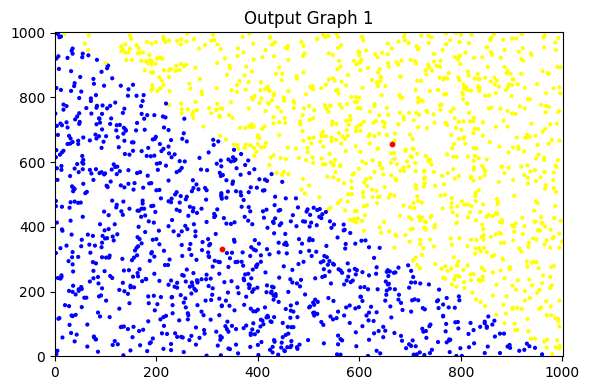

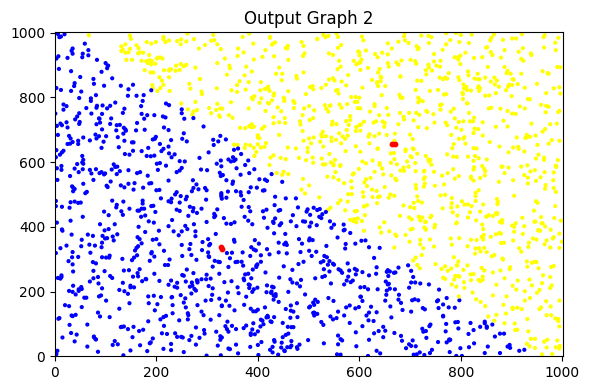

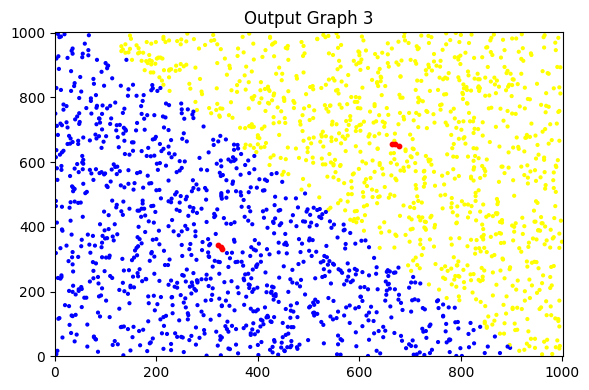

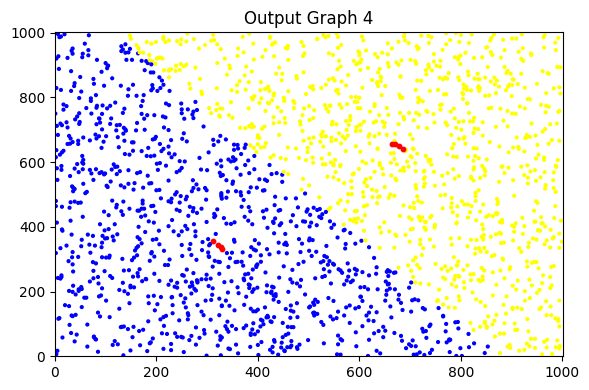

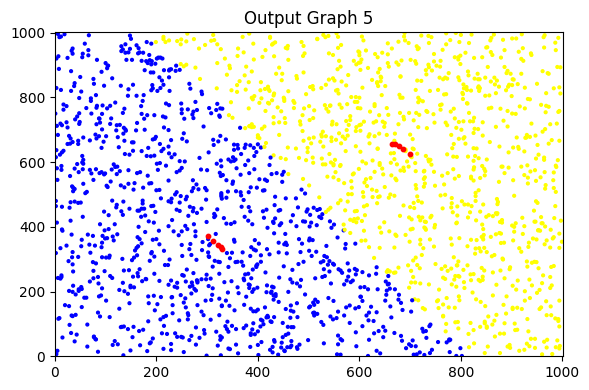

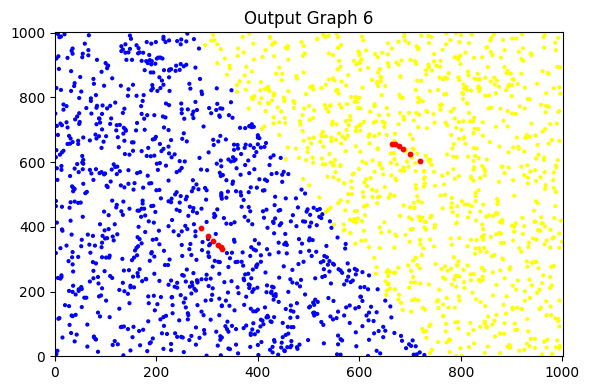

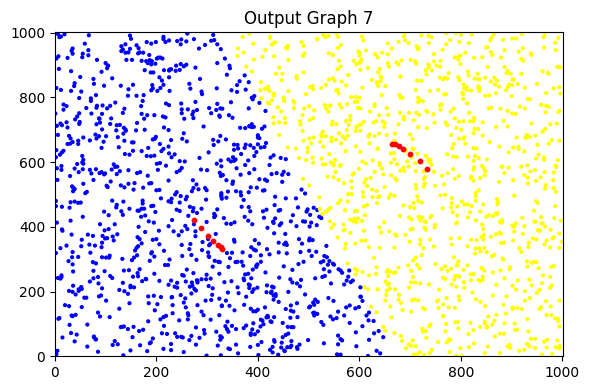

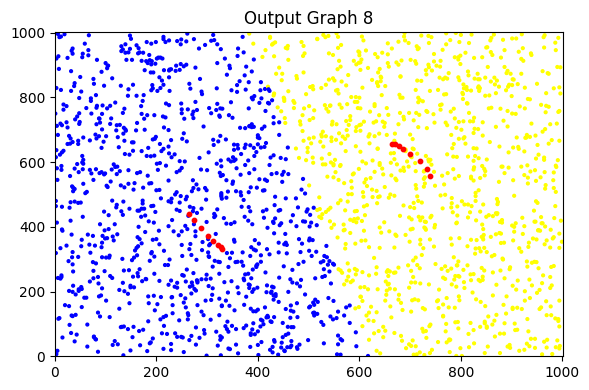

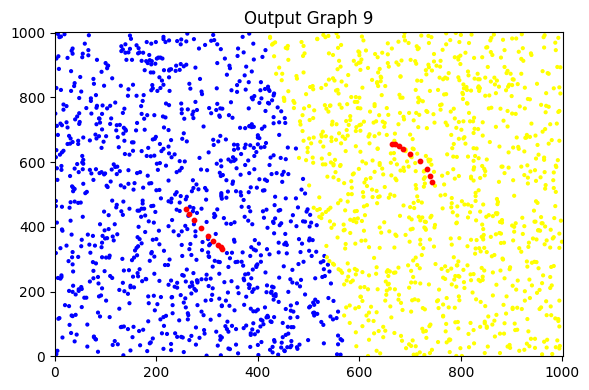

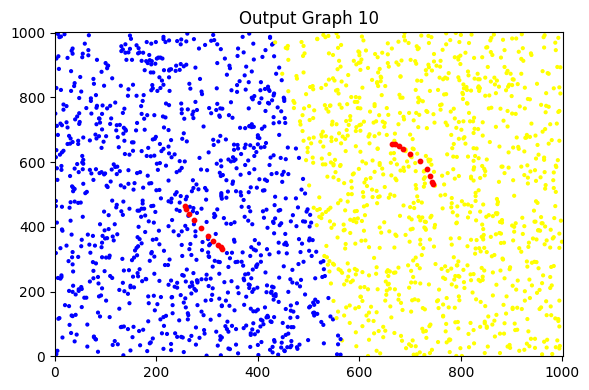

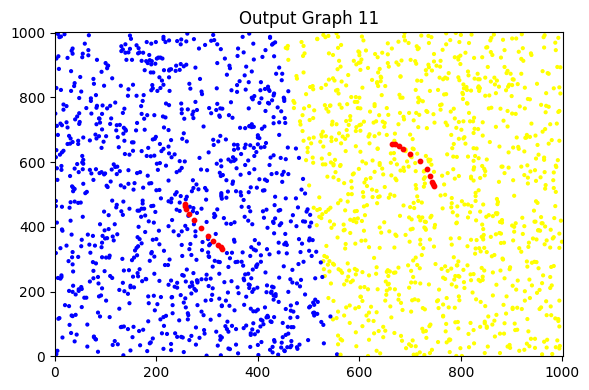

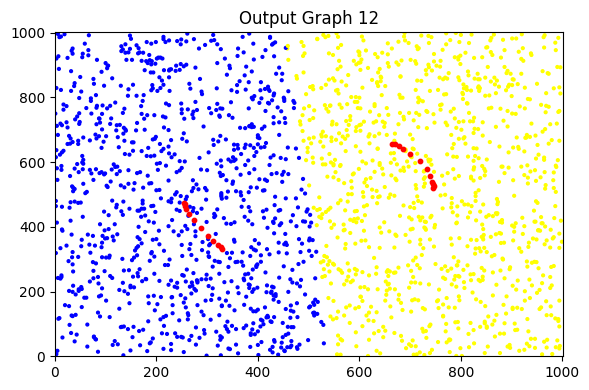

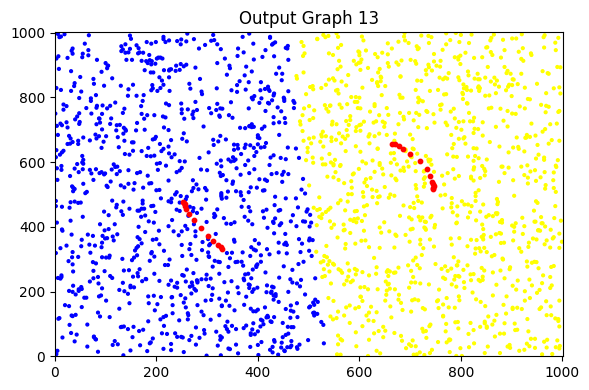

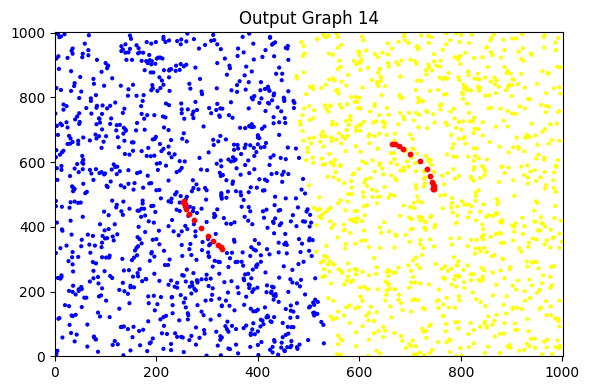

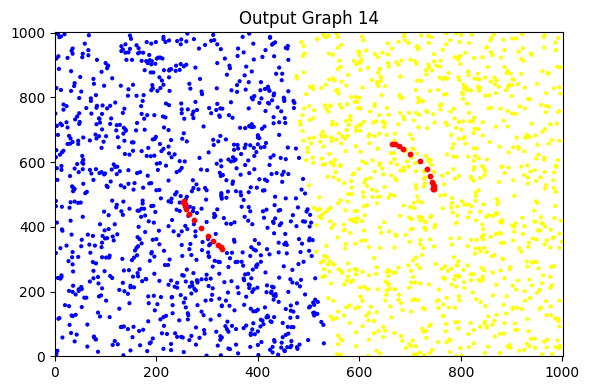

In [13]:
#iterate the process until convergence is reached
convergence = False
coordinates = []
i = 1
while(convergence==False):
  coordinates.append([[data[data["Cluster"]=="cluster1"]["X"].mean(),data[data["Cluster"]=="cluster2"]["X"].mean()],[data[data["Cluster"]=="cluster1"]["Y"].mean(),data[data["Cluster"]=="cluster2"]["Y"].mean()]])# >:|
  punti,data,validation = getCentroids(all_points,punti,data)
  getClusterGraph(punti_generati,punti,i,coordinates)
  if(validation == data["Cluster"].tolist()):
    convergence = True
  else:
    i = i+1
    data["Cluster"] = validation
    getCentroids(all_points,punti,data)
getClusterGraph(punti_generati,punti,i,coordinates)

In [0]:
#Create the giph of the clusterization progress combining all the images created
import os 
import imageio
picture = ['drive/My Drive/'+str(x) for x in os.listdir('drive/My Drive/') if "png" in x]

images = []
for filename in picture:
    images.append(imageio.imread(filename))
imageio.mimsave('drive/My Drive/Cluster/Clusterization.gif', images,duration=0.5)

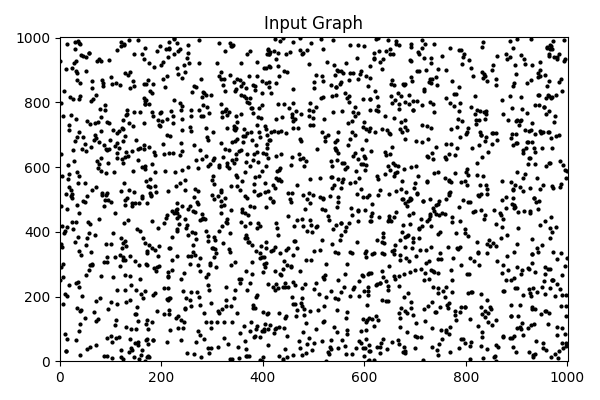

In [15]:
#see the results
from IPython.display import Image
with open("drive/My Drive/Cluster/Clusterization.gif",'rb') as f:
    display(Image(data=f.read(), format='png'))

**To sum up**

Using Euclidean Distance is not a great way to achieve clusters,first of all because the slope that discretize the cluster will be always straight, and second because you always have to define the number of cluster before running the algorithm.

The potential of a dynamic clusterization algorithm lies dormant in matter,